In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import sklearn
from sklearn_pandas import DataFrameMapper
matplotlib.style.use('ggplot')
%matplotlib inline

In [87]:
df = pd.read_csv('india_surroundings_1mar2016 _28_feb_2017.csv')
del df['IRIS ID'], df['Year'], df['Month'], df['Day'], df['Time UTC']
df = df.iloc[::-1]
df = pd.get_dummies(df)

In [88]:
train_test_ratio = .7
train_size = int(df.shape[0] * train_test_ratio)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [89]:
mapper = DataFrameMapper([
       # (['Region'], None),
        (['Mag'],sklearn.preprocessing.StandardScaler()),
        (['Depth km'],sklearn.preprocessing.StandardScaler()),
        (['Lat'],sklearn.preprocessing.StandardScaler()),
        (['Lon'],sklearn.preprocessing.StandardScaler()),
        (['Timestamp'], sklearn.preprocessing.StandardScaler()) 
    ],default = None)
train_data = mapper.fit_transform(train_data)
#train_data[['Mag','Lat','Lon','Timestamp','Depth km']] = train_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)
test_data = mapper.transform(test_data)
#test_data[['Mag','Lat','Lon','Timestamp','Depth km']] = test_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)


/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Training set loss:
lr decreased to 6.6499999999999995
Epoch 0 avg. batch loss 411.307
Test set loss: 355.699
Mag loss: 2.506
Lat loss: 2.42
Lon loss: 2.367
Depth km loss: 1.955
Timestamp loss: 2.431
Region_AFGHANISTAN loss: 2.372
Region_AFGHANISTAN-TAJIKISTAN BORD REG. loss: 2.315
Region_ANDAMAN ISLANDS, INDIA loss: 2.323
Region_ANDAMAN ISLANDS, INDIA REGION loss: 2.489
Region_EASTERN KASHMIR loss: 2.21
Region_EASTERN XIZANG-INDIA BORDER REG. loss: 2.27
Region_HINDU KUSH REGION, AFGHANISTAN loss: 2.388
Region_INDIA-BANGLADESH BORDER REGION loss: 2.618
Region_INDIA-PAKISTAN BORDER REG. loss: 2.542
Region_KASHMIR-XINJIANG BORDER REGION loss: 2.332
Region_KASHMIR-XIZANG BORDER REGION loss: 2.384
Region_MYANMAR loss: 2.628
Region_MYANMAR-INDIA BORDER REGION loss: 2.49
Region_NEPAL loss: 2.502
Region_NEPAL-INDIA BORDER REGION loss: 2.259
Region_NICOBAR ISLANDS, INDIA loss: 2.272
Region_NORTHEASTERN INDIA loss: 2.278
Region_NORTHERN INDIA loss: 2.588
Region_NORTHWESTERN KASHMIR loss: 2.541
R

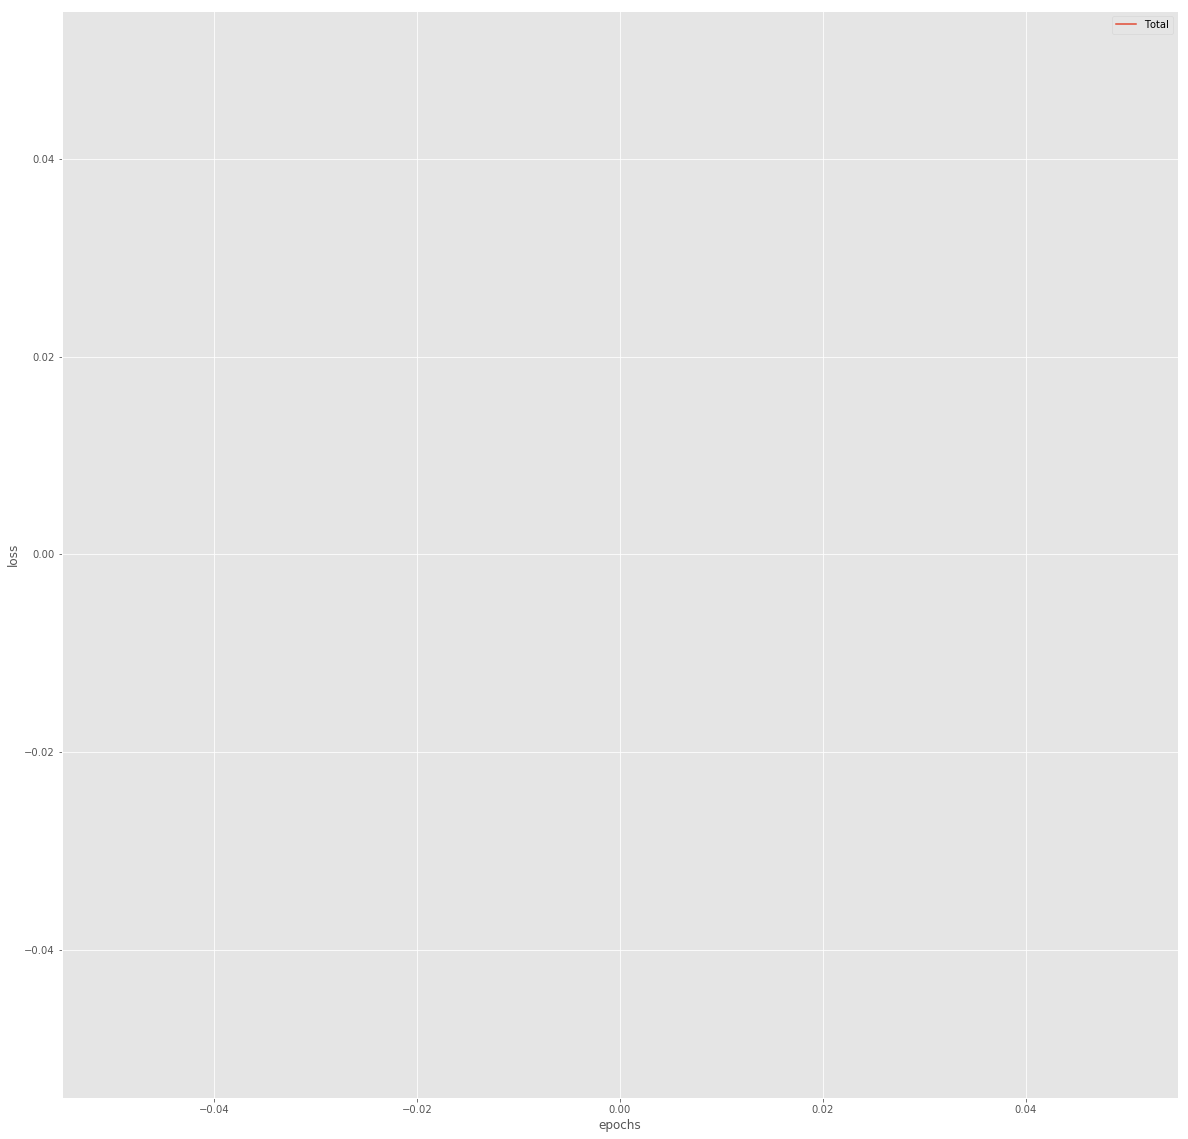

In [91]:
num_epochs = 1
truncated_backprop_length = 15
state_size = 100
echo_step = 3
batch_size = 4 # must be a factor of train data and test data size
total_series_length, num_features = train_data.shape
num_outputs = num_features
num_batches = total_series_length - (total_series_length//batch_size*(batch_size-1) + truncated_backprop_length-1)
num_layers = 2
x = train_data
y = np.roll(x, echo_step)
y[0:echo_step] = np.zeros(num_features)
x = x.reshape((batch_size, -1, num_features))
y = y.reshape((batch_size, -1, num_features))

xtest = test_data
ytest = np.roll(xtest, echo_step)
ytest[0:echo_step] = np.zeros(num_features)
xtest = xtest.reshape((batch_size, -1, num_features))
ytest = ytest.reshape((batch_size, -1, num_features))
total_series_length, _ = test_data.shape
num_batches_test = total_series_length - (total_series_length//batch_size*(batch_size-1) + truncated_backprop_length-1)

graph = tf.Graph()
with graph.as_default():

    batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length, num_features])
    batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length, num_features])
    keep_prob = tf.placeholder(tf.float32)
    init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

    state_per_layer_list = tf.unstack(init_state, axis=0)
    rnn_tuple_state = tuple([tf.contrib.rnn.core_rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
                   for idx in range(num_layers)])

    W = tf.Variable(np.random.rand(state_size+num_features, state_size), dtype=tf.float32)
    b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

    W2 = tf.Variable(np.random.rand(state_size, num_outputs),dtype=tf.float32)
    b2 = tf.Variable(np.zeros((1,num_outputs)), dtype=tf.float32)

    # Forward passes
    cell = tf.contrib.rnn.core_rnn_cell.LSTMCell(state_size, state_is_tuple=True)
    cell = tf.contrib.rnn.core_rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
    cell = tf.contrib.rnn.core_rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)

    states_series, current_state = tf.nn.dynamic_rnn(cell, batchX_placeholder, initial_state=rnn_tuple_state)
    states_series = tf.reshape(states_series, [-1, state_size])

    outputs = tf.matmul(states_series, W2) + b2
    targets = tf.reshape(batchY_placeholder, [-1, num_features])

    losses = tf.sqrt(tf.reduce_mean(tf.squared_difference(outputs, targets),0))
    total_loss = tf.reduce_sum(losses)
    step = tf.Variable(0, trainable=False)
    learning_rate = tf.placeholder(tf.float32)
    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss, global_step = step)

batchesX = []
batchesY = []
for batch_idx in range(num_batches):
    start_idx = batch_idx
    end_idx = start_idx + truncated_backprop_length

    batchesX.append(x[:, start_idx:end_idx])
    batchesY.append(y[:, start_idx:end_idx])
            
loss_list = []
#indv_loss_list = []
lr = 7
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Training set loss:')
    for epoch_idx in range(num_epochs):

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))
        batch_loss = [] 
        #batch_indv_loss = []
        for batch_idx in range(num_batches):

            _total_loss, _train_step, _current_state = sess.run(
                [total_loss, train_step, current_state],
                feed_dict={
                    batchX_placeholder: batchesX[batch_idx],
                    batchY_placeholder: batchesY[batch_idx],
                    init_state: _current_state,
                    keep_prob: 0.5,
                    learning_rate: lr
                })
            #batch_indv_loss.append(np.mean(indv_losses,axis=0))
            batch_loss.append(_total_loss) 
            
        loss_list.append(np.mean(batch_loss))
        if np.argmin(loss_list[-10:]) == 0:
            lr *= .95
            print('lr decreased to', lr)
        #indv_loss_list.append(np.mean(np.sqrt(batch_indv_loss),axis=0))
        if epoch_idx % 50 == 0:
                print("Epoch", epoch_idx, "avg. batch loss", np.mean(batch_loss)) 
    
    _current_state = np.zeros((num_layers, 2, batch_size, state_size))
    batch_indv_loss = []
    for batch_idx in range(num_batches_test):
        start_idx = batch_idx
        end_idx = start_idx + truncated_backprop_length
        
        batchX = xtest[:, start_idx:end_idx]
        batchY = ytest[:, start_idx:end_idx]
        
        _total_loss, indv_losses = sess.run(
                [total_loss, losses],
                feed_dict={
                    batchX_placeholder: batchesX[batch_idx],
                    batchY_placeholder: batchesY[batch_idx],
                    init_state: _current_state,
                    keep_prob: 1
                })
        batch_indv_loss.append(indv_losses)     
        batch_loss.append(_total_loss)
#indv_loss_list = np.array(indv_loss_list)
indv_loss = np.mean(batch_indv_loss, axis=0)
print('Test set loss:', np.mean(batch_loss))
for i, col in enumerate(df.columns):
    print(col + ' loss:', np.round(indv_loss[i],3))
plt.figure(figsize=(20,20))
#for i, col in enumerate(train_data.columns):
#    plt.plot(indv_loss_list[50:,i], label = col)
plt.plot(loss_list[50:], label='Total')
#plt.plot(np.convolve(loss_list[50:], np.ones((10,))/10, mode='valid'), color='black', label='Total (Smooth)')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()
    


In [86]:
ien = [1 ,2 ,3 ,4 ,5 ,6]
np.argmin(ien[-5:])

0